## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from skimage import io
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
10066,00002611_003.png,Infiltration,3,2611,54,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_002/images/00002611_003.png
80565,00019782_002.png,Infiltration,2,19782,46,M,PA,2528,3056,0.139000,0.139000,NaN,/data/images_009/images/00019782_002.png
91516,00022826_025.png,Infiltration|Pleural_Thickening,25,22826,61,M,PA,2698,2991,0.143000,0.143000,NaN,/data/images_010/images/00022826_025.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: 
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['Pneumonia Class'] = all_xray_df.Pneumonia.astype(str)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    # Set the test_size to 0.2 or 20% of the data set
    train_df, valid_df = train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    
    return train_df, valid_df

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
#224 x 224 is the typical input image size to the VGG16 NN
IMG_SIZE = (224, 224)

In [7]:
train_df, valid_df = create_splits(all_xray_df)

In [18]:
#Update train_df to have a balance of Pneumonia and non-Pneumonia cases
pneumo_cases = train_df[train_df.Pneumonia==1]
num_pneumo_cases = len(pneumo_cases)
non_pneumo_cases = train_df[train_df.Pneumonia==0][0:num_pneumo_cases]
new_train_df = pd.concat([pneumo_cases, non_pneumo_cases],axis=0)

#Shuffle data in datasset
new_train_df = new_train_df.sample(frac=1)

In [19]:
#Update valid_df to be a smaller sized dataset and have a 1:3 imbalance of Pneumonia and non-Pneumonia cases
pneumo_cases_v = valid_df[valid_df.Pneumonia==1]
num_pneumo_cases_v = len(pneumo_cases_v)
non_pneumo_cases_v = valid_df[valid_df.Pneumonia==0][0:(num_pneumo_cases_v*3)]
new_valid_df = pd.concat([pneumo_cases_v, non_pneumo_cases_v],axis=0)

#new_valid_df size is now 1144
#Shuffle data in datasset
new_valid_df = new_valid_df.sample(frac=1)

In [20]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return train_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Todo

    my_train_idg = my_image_augmentation(vargs)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                     directory=None, 
                                     x_col = 'path',
                                     y_col = 'Pneumonia Class',
                                     class_mode = 'binary',
                                     target_size = IMG_SIZE, 
                                     batch_size = 32)

    return train_gen


def make_val_gen(vargs):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)

    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia Class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)
    

    return val_gen

In [21]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(new_valid_df)
valX, valY = val_gen.next()

Found 1144 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


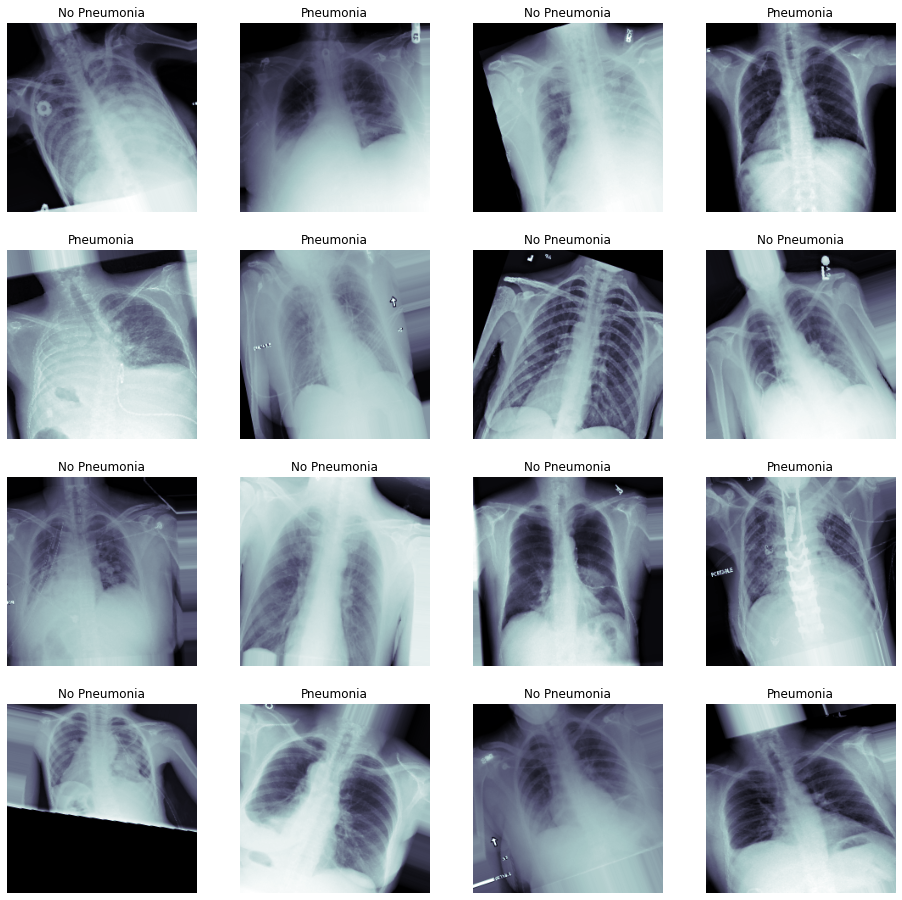

In [22]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_train_gen(new_train_df)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [23]:
def load_pretrained_model():
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [24]:
vgg = load_pretrained_model()
vgg.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [25]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    #Load pretrained model VGG16 model
    
    #Freeze frist 18 layers
    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False
    
    my_model = Sequential()
    
    my_model.add(pretrained_model)
    
    #Build Model 
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    ## Set optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-6)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= "loss", 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [27]:
## train your model

# Todo
my_model = build_my_model(vgg)

In [28]:
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
72/72 [==============================] - 66s 916ms/step - loss: 0.7615 - binary_accuracy: 0.5026 - val_loss: 0.7151 - val_binary_accuracy: 0.3750

Epoch 00001: loss improved from inf to 0.76003, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 59s 821ms/step - loss: 0.7526 - binary_accuracy: 0.5031 - val_loss: 0.7264 - val_binary_accuracy: 0.3125

Epoch 00002: loss improved from 0.76003 to 0.75272, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
72/72 [==============================] - 59s 818ms/step - loss: 0.7466 - binary_accuracy: 0.5070 - val_loss: 0.7231 - val_binary_accuracy: 0.3125

Epoch 00003: loss improved from 0.75272 to 0.74681, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
72/72 [==============================] - 59s 824ms/step - loss: 0.7552 - binary_accuracy: 0.4969 - val_loss: 0.7197 - val_binary_accuracy: 0.3125

Epoch 00004: loss did not improve from 0.74681
Epoch 5/30
72/72 [=============

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [29]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


In [30]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    

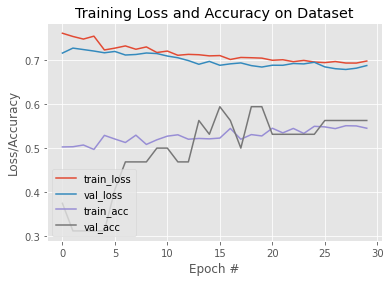

In [31]:
## plot training history
plot_history(history)

In [61]:
ground_truth = valY


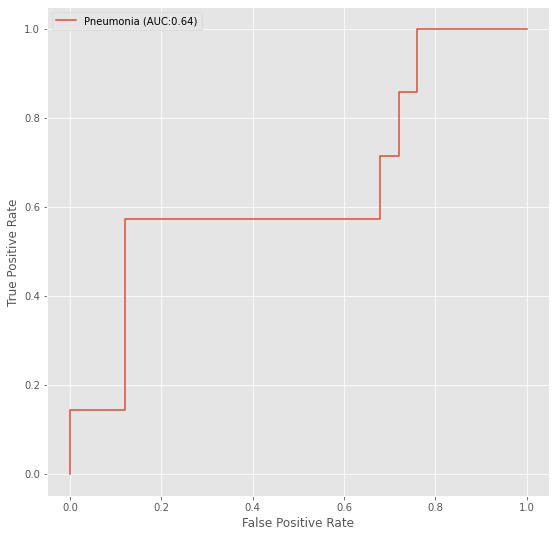

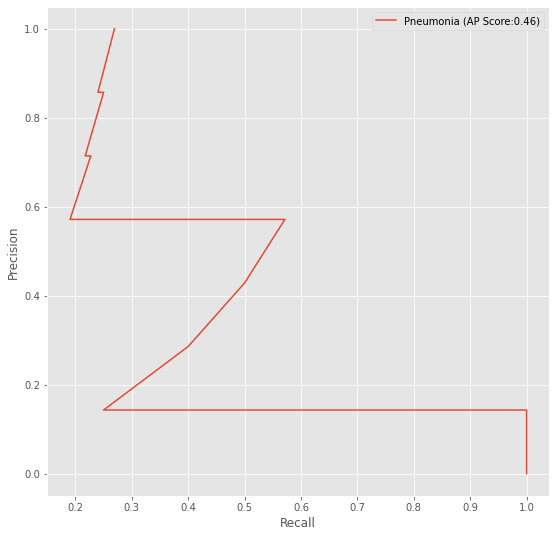

In [62]:
# Todo
plot_auc(ground_truth,pred_Y)
plot_pr(ground_truth,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [68]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
# from the sci-kit documentation: Last precision and recall values are 0 and 1 respectively for graphing purposes only
precision, recall, thresholds = precision_recall_curve(ground_truth,pred_Y)
f1_scores = calc_f1(precision, recall)

def plot_f1_threshold(t, f1):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(t, f1)
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Scores')
    
    return

def calc_max_f1(p, r, t):
    idx = 1
    precision = p[0]
    recall = r[0]
    threshold = t[0]
    max_f1 = calc_f1(precision, recall)
    
    while idx < len(t):
        if calc_f1(p[idx], r[idx]) > max_f1:
            precision = p[idx]
            recall = r[idx]
            threshold = t[idx]
            max_f1 = calc_f1(p[idx], r[idx]) 
        idx += 1
        
    print('Precision is: '+ str(precision))
    print('Recall is: '+ str(recall))
    print('Threshold is: '+ str(threshold))
    print('F1 Score is: ' + str(max_f1))
    

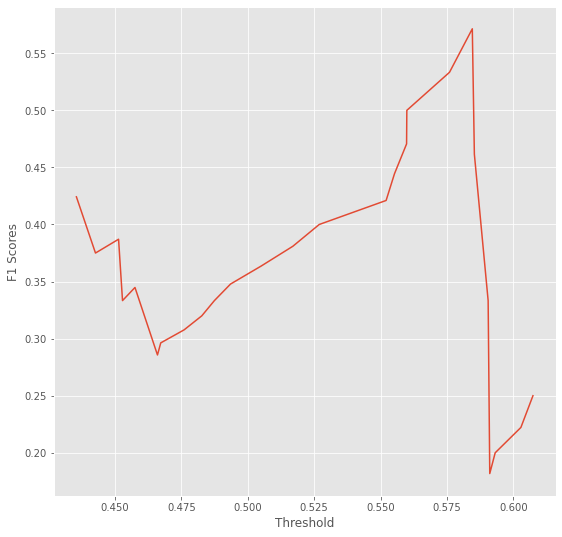

In [69]:
plot_f1_threshold(thresholds, f1_scores[0:26])

In [70]:
calc_max_f1(precision, recall, thresholds)

Precision is: 0.5714285714285714
Recall is: 0.5714285714285714
Threshold is: 0.584543
F1 Score is: 0.5714285714285714


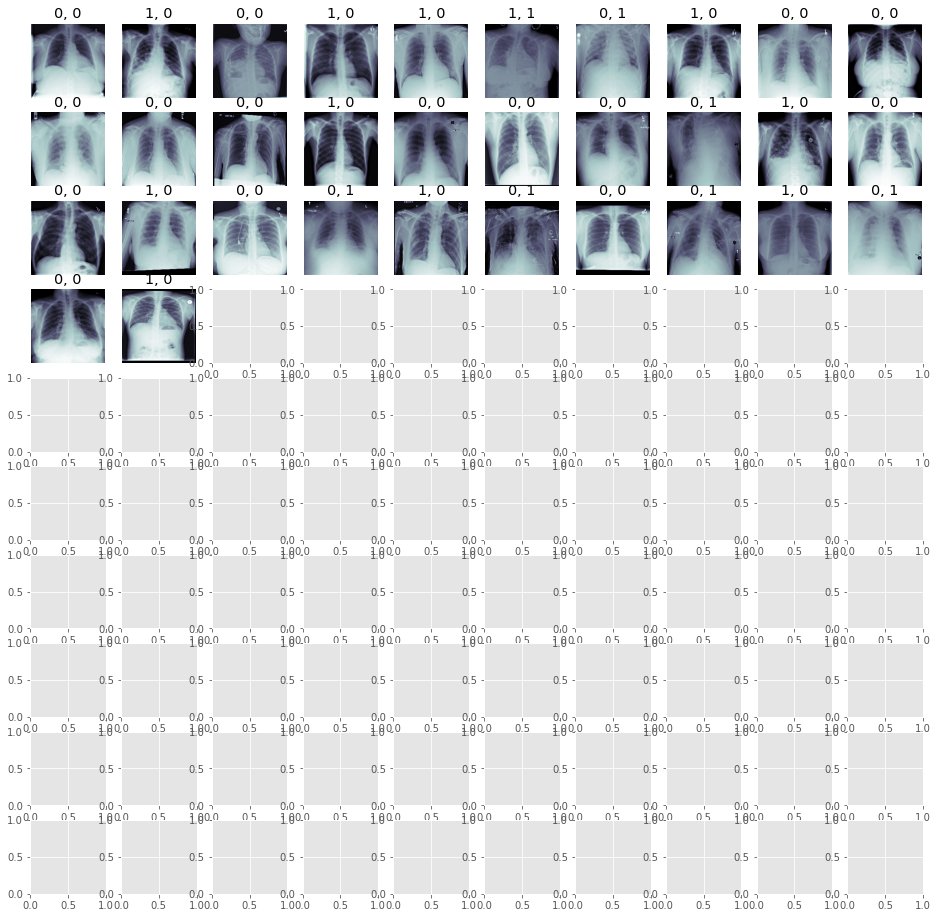

In [71]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
testX, testY = next(train_gen)
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.584:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.584: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [72]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_ssheikhAIHCND.json", "w") as json_file:
    json_file.write(model_json)